In [1]:
import os
import sys
import time
import numpy as np
import imgaug
import shutil
import skimage.io as io
import json
import matplotlib.pyplot as plt
import random

ROOT_DIR = os.path.abspath('../')
sys.path.append(ROOT_DIR)

from config import Config
import model as modellib
import utils

import dataset_tool.dataset as dataset_tool
import dataset_tool.categories as categories
from dataset_tool.settings import *
from s3d import *
import visualize

Using TensorFlow backend.


In [2]:
config = S3DConfig()
config.BATCH_SIZE = 1
config.IMAGES_PER_GPU = 1

trainset = S3DDataset()
trainset.load_s3d('train')
trainset.prepare()

testset = S3DDataset()
testset.load_s3d('test')
testset.prepare()

In [3]:
# Create model object in inference mode.

model = modellib.MaskRCNN(mode="inference", model_dir='.', config=config)

# Load weights trained on MS-COCO
def find_latest(s):
    for i in range(1000, -1, -1):
        if os.path.exists(s % i):
            return s % i
LOAD_WEIGHT_PATH = find_latest('/home/xuanrun/Scene/logs/maskrcnn_baseline/s3d20191119T2348/mask_rcnn_s3d_%04d.h5')
model.load_weights(LOAD_WEIGHT_PATH, by_name=True)

Re-starting from epoch 399


{'scale': array([0.8], dtype=float32), 'original_image_shape': array([[ 720, 1280,    3]], dtype=int32), 'image_id': array([2630], dtype=int32), 'image_shape': array([[1024, 1024,    3]], dtype=int32), 'active_class_ids': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int32), 'window': array([[ 224,    0,  800, 1024]], dtype=int32)}


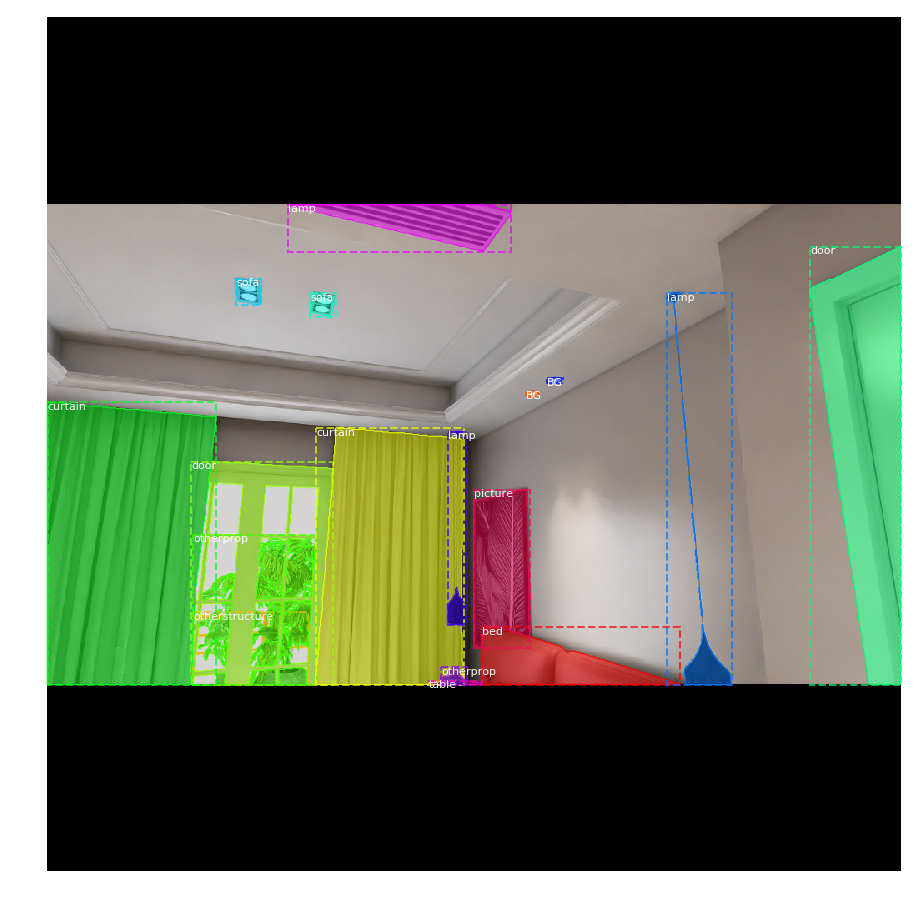

In [8]:
image, meta, class_ids, bbox, mask = modellib.load_image_gt(testset, config, random.randint(0, len(testset.image_info)))
# image, meta, class_ids, bbox, mask = modellib.load_image_gt(testset, config, 0)
print(modellib.parse_image_meta(meta))

visualize.display_instances(image, bbox, mask, class_ids, [categories.category2name(i) for i in range(categories.cate_cnt)])

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 53)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


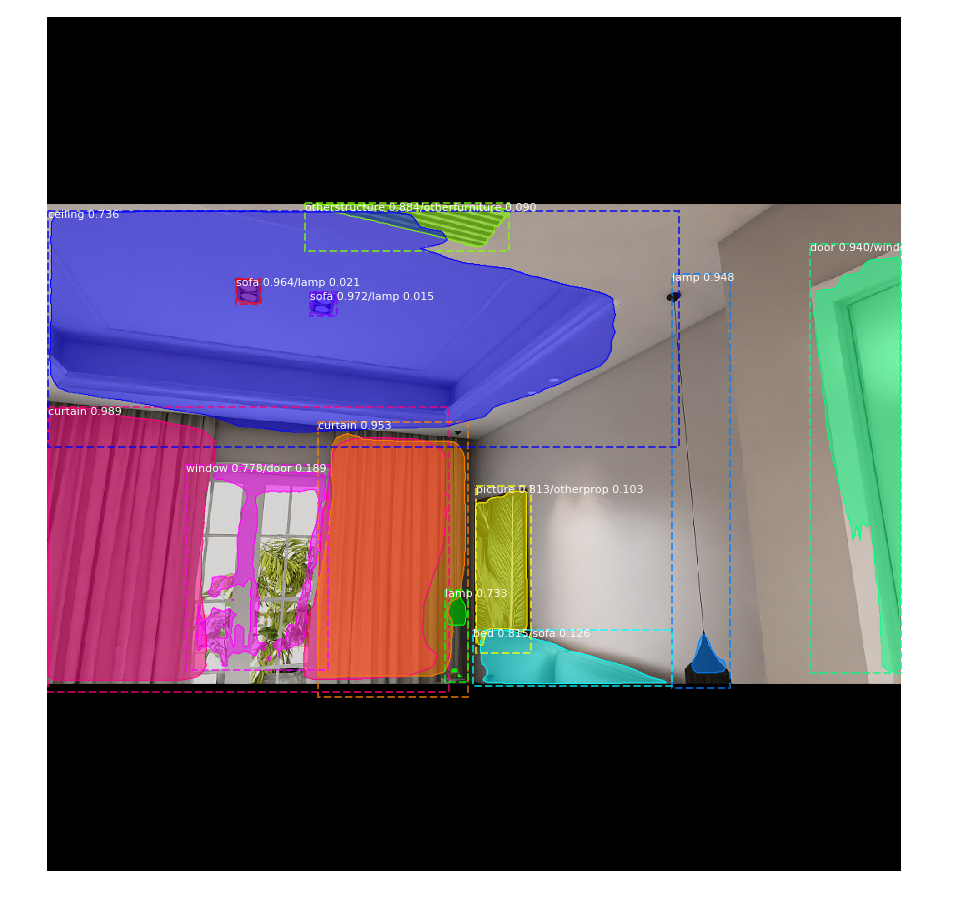

In [9]:
# Run detection

results = model.detect([image], verbose=1)
# Visualize results
class_names = [categories.category2name(i) for i in range(categories.cate_cnt)]

r = results[0]
visualize.display_instances_second_class(image, r['rois'], r['masks'], r['class_ids'], r['second_class_ids'], class_names, r['scores'], r['second_scores'])